In [140]:
DEBUG = True

In [141]:
#TODO: Take 10%, do our experiment, and then take 80% to train and use the other 10% to test.
#TODO: Pearsons R score for deciding what to use.



In [142]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from datetime import datetime
import math
from sklearn.metrics import r2_score
import pandas as pd
from scipy.stats import pearsonr
from deap import base, creator, tools

random.seed(42)
np.random.seed(42)


## Data Import & Cleaning

In [143]:
all_data = pd.read_csv('eScooterDemand.csv')


Splitting the date into Month, Year and Day means that we can use them as features seperately

In [144]:
all_data['Date'] = pd.to_datetime(all_data['Date'], format='%d/%m/%Y')
all_data['Month'] = all_data['Date'].dt.month.astype('int64')
all_data['Year'] = all_data['Date'].dt.year.astype('int64')
all_data['Day'] = all_data['Date'].dt.day.astype('int64')
all_data['Weekday'] = all_data['Date'].dt.weekday.astype('int64')
all_data['Weekend'] = all_data['Date'].dt.dayofweek.map(lambda x: 1 if x > 4 else 0).astype('int64')


all_data.drop(columns='Date', inplace=True)

all_data['HireAvailable'] = all_data['HireAvailable'].map({'Yes': 1, 'No': 0}).astype('int64')
all_data['Public Holiday'] = all_data['Public Holiday'].map({'Yes': 1, 'No': 0}).astype('int64')
all_data['Season'] = all_data['Season'].map({'Spring': 0, 'Summer': 1, 'Autumn': 2, 'Winter': 3}).astype('int64')

In [145]:
all_data.head()

,Count,Hour,Temp,Humidity,Wind speed,Visibility,Dew point,Sunshine,Rain,Snow,Season,Public Holiday,HireAvailable,Month,Year,Day,Weekday,Weekend
0,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,3,0,1,12,2017,1,4,0
1,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,3,0,1,12,2017,1,4,0
2,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,3,0,1,12,2017,1,4,0
3,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,3,0,1,12,2017,1,4,0
4,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,3,0,1,12,2017,1,4,0


all_d

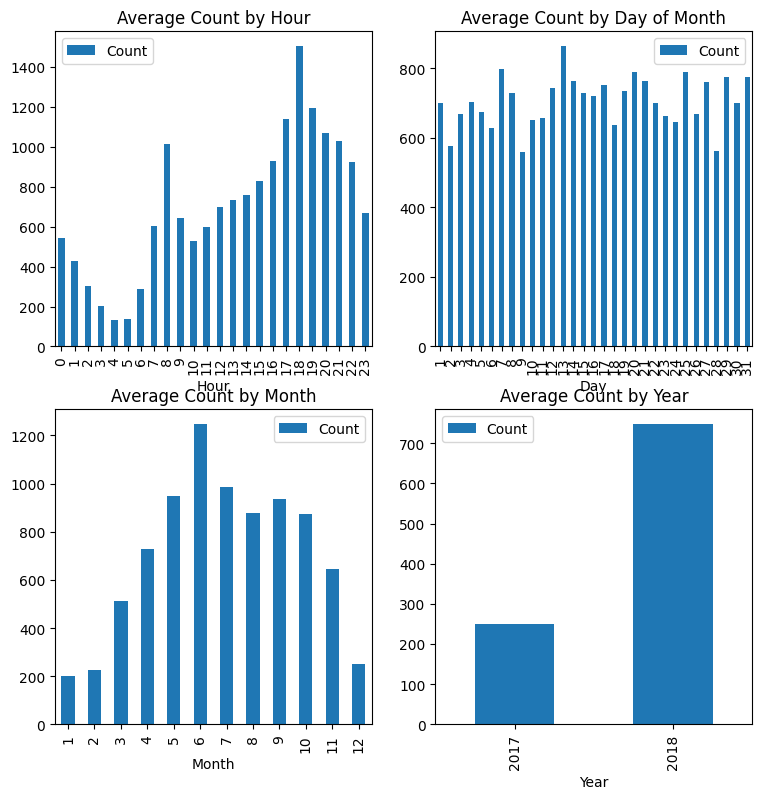

In [146]:
## Show all plots on one figure
fig, ax = plt.subplots(2, 2, figsize=(9, 9))
all_data.groupby('Hour').aggregate({'Count': 'mean'}).plot(kind='bar', ax=ax[0, 0], title='Average Count by Hour')
all_data.groupby('Day').aggregate({'Count': 'mean'}).plot(kind='bar', ax=ax[0, 1], title='Average Count by Day of Month')
all_data.groupby('Month').aggregate({'Count': 'mean'}).plot(kind='bar', ax=ax[1, 0], title='Average Count by Month')
all_data.groupby('Year').aggregate({'Count': 'mean'}).plot(kind='bar', ax=ax[1, 1], title='Average Count by Year')

plt.show()


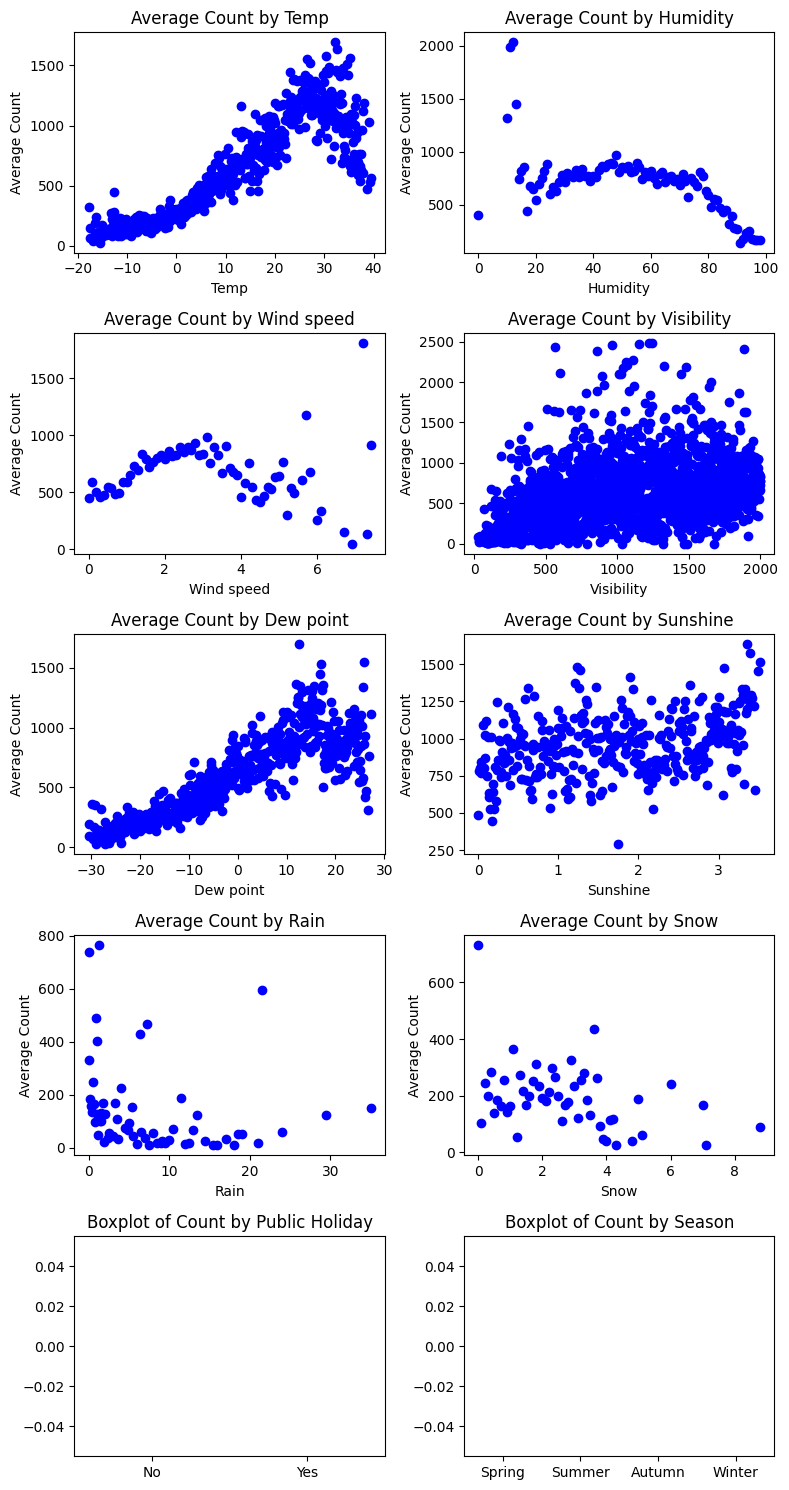

In [147]:

columns_to_plot = ['Temp', 'Humidity', 'Wind speed', 'Visibility', 'Dew point', 'Sunshine', 'Rain', 'Snow']

fig, ax = plt.subplots(5, 2, figsize=(8, 15))

ax = ax.flatten()

# Plot each column against the count of rentals
for i, col in enumerate(columns_to_plot):
    # Group data by the current column and calculate average count of rentals
    average_rental_counts = all_data.groupby(col)['Count'].mean().reset_index()
    
    # Plot the data
    ax[i].scatter(average_rental_counts[col], average_rental_counts['Count'], color='blue')
    ax[i].set_title(f'Average Count by {col}')
    ax[i].set_xlabel(col)
    ax[i].set_ylabel('Average Count')

# Plot boxplot for season in the last subplot
seasons = ['Spring', 'Summer', 'Autumn', 'Winter']
boxplot_data = [all_data[all_data['Season'] == season]['Count'] for season in seasons]
ax[-1].boxplot(boxplot_data, labels=seasons, showfliers=False)
ax[-1].set_title('Boxplot of Count by Season')

# boxplot for public holiday
public_holidays = ['No', 'Yes']
boxplot_data = [all_data[all_data['Public Holiday'] == holiday]['Count'] for holiday in public_holidays]
ax[-2].boxplot(boxplot_data, labels=public_holidays, showfliers=False)
ax[-2].set_title('Boxplot of Count by Public Holiday')

plt.tight_layout()

plt.show()

From this we can see that there is a clear causation between the number of scooters hired and the temperature, humidity, sunshine, windspeed and dew point as they show a gradient or bell curve in the diagrams. There is also a pattern to the average count relation to snow and rain.
We can also see a difference in means and ranges in the different seasons.
However, it is hard to tell for some of them, such as visibility, so we will calculate the pearson r score for each.


In [148]:

p_values = {}

for column in all_data.columns:
    if column == 'Count':
        continue 
    if all_data[column].dtype in ['int64', 'float64']:  # Check if the column contains numeric data
        correlation_coefficient, p_value = pearsonr(all_data[column], all_data['Count'])
        p_values[column] = {'p_value': p_value, 'significant': p_value < 0.01}
    else:
        p_values[column] = {'p_value': None, 'significant': False}

# Convert dictionary to DataFrame for better visualization
p_values_df = pd.DataFrame.from_dict(p_values, orient='index', columns=['p_value', 'significant'])

# Sort DataFrame by p-value in ascending order
p_values_df = p_values_df.sort_values(by='p_value')

print(p_values_df)
feature_list = p_values_df.query('significant').index.tolist()



                      p_value  significant
Hour             0.000000e+00         True
Temp             0.000000e+00         True
Dew point       1.325584e-298         True
Season          5.268073e-178         True
Sunshine        2.780395e-137         True
Year             2.830579e-92         True
HireAvailable    6.732211e-83         True
Humidity         1.475065e-79         True
Visibility       3.672704e-79         True
Snow             1.398012e-40         True
Month            3.942026e-36         True
Rain             6.462816e-31         True
Wind speed       5.544562e-30         True
Public Holiday   1.215644e-11         True
Weekend          6.406093e-04         True
Weekday          5.997997e-03         True
Day              3.695363e-02        False


From the R2 scores, if we are using significance of < 0.01 then we can see that all the data points are statistically signigicant other than Day.

In [149]:
all_data = all_data.drop(columns=['Day'])

## Data normalization
In order to normalize the data we will use the MinMaxScaler from sklearn.preprocessing. This will scale the data to be between 0 and 1. This is important as the data is on different scales and we want to make sure that the model is not biased towards the larger values. We are only scaling the numerical data rather than the catagorical data such as HireAvailable and Month. We are also not scaling the target variable as we want to be able to interpret the results in terms of the original data.
Lastly we are scaling the year data as it is a numerical value and we want to make sure that it is closer to being on the same scale as the other numerical data.

In [150]:
from sklearn import preprocessing

features = ['Temp',
'Wind speed',
'Visibility',
'Dew point',
'Sunshine',
'Rain',
'Snow',
'Humidity'
]


print(all_data[features].describe())
normalised_data = all_data.copy()

# for feature in features:
scaler = preprocessing.MinMaxScaler((-1, 1))
# Fit the scaler to your data
scaler.fit(normalised_data[features])

# Transform the selected features
normalised_data[features] = scaler.transform(normalised_data[features])

normalised_data['Year'] = (normalised_data['Year'] - 2018)/10
normalised_data['Month'] = normalised_data['Month']/12




              Temp   Wind speed   Visibility    Dew point     Sunshine  \
count  8760.000000  8760.000000  8760.000000  8760.000000  8760.000000   
mean     12.882922     1.724909  1436.825799     4.073813     0.569111   
std      11.944825     1.036300   608.298712    13.060369     0.868746   
min     -17.800000     0.000000    27.000000   -30.600000     0.000000   
25%       3.500000     0.900000   940.000000    -4.700000     0.000000   
50%      13.700000     1.500000  1698.000000     5.100000     0.010000   
75%      22.500000     2.300000  2000.000000    14.800000     0.930000   
max      39.400000     7.400000  2000.000000    27.200000     3.520000   

              Rain         Snow     Humidity  
count  8760.000000  8760.000000  8760.000000  
mean      0.148687     0.075068    58.226256  
std       1.128193     0.436746    20.362413  
min       0.000000     0.000000     0.000000  
25%       0.000000     0.000000    42.000000  
50%       0.000000     0.000000    57.000000  
75% 

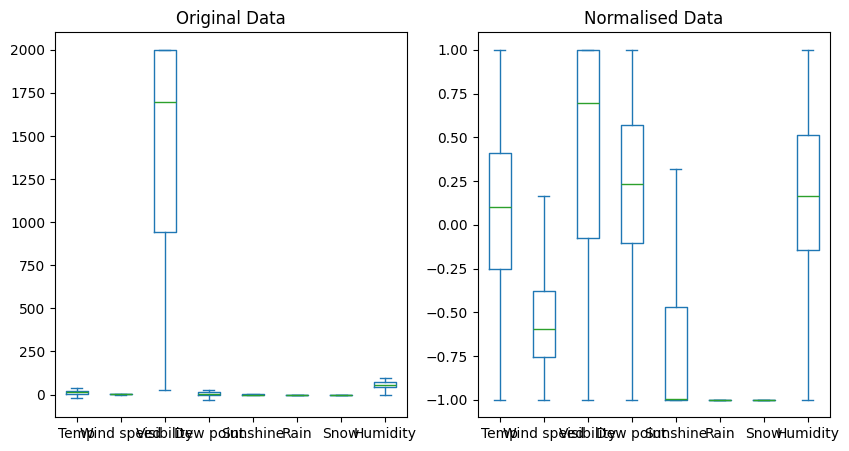

In [151]:
## visualise on boxplot
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
all_data[features].plot(kind='box', ax=ax[0], title='Original Data', showfliers=False)
normalised_data[features].plot(kind='box', ax=ax[1], title='Normalised Data', showfliers=False)
plt.show()


## Setting up our model
I will be using a multilayer perceptron with 2 hidden layers for my model. 
This is because I struggled to get good results with only 1 layer, and 3 layers took too long to train. 

In [152]:
class MLP(object):
    """
    Multi-layer perceptron class
    """
    def __init__(self, numInput, numHidden1, numHidden2, numOutput):
        """
        Constructor for the MLP class

        Args:
            numInput (int): Number of input nodes
            numHidden1 (int): Number of nodes in hidden layer 1
            numHidden2 (int): Number of nodes in hidden layer 2
            numOutput (int): Number of output nodes
        """
        
        self.fitness = 0
        self.numInput = numInput
        self.numHidden1 = numHidden1
        self.numHidden2 = numHidden2
        self.numOutput = numOutput

        # weights between layers are randomly initialized
        self.w_i_h1 = np.random.randn(self.numHidden1, self.numInput)
        self.w_h1_h2 = np.random.randn(self.numHidden2, self.numHidden1)
        self.w_h2_o = np.random.randn(self.numOutput, self.numHidden2)

        # bias between layers are initialized to 0
        self.b_i_h1 = [0] * numHidden1 
        self.b_i_h2 = [0] * numHidden2
        self.b_i_output = [0] * numOutput

        self.ReLU = lambda x : max(0,x)

    def sigmoid(self,x: float) -> float:
        """ Sigmoid activation function """
        try:
            ans = (1 / (1 + math.exp(-x)))
        except OverflowError:
            ans = float('inf')
        return ans

    def softmax(self, x: np.ndarray) -> np.ndarray:
        """ Compute softmax values for each sets of scores in x """
        e_x = np.exp(x - np.max(x))
        return e_x / e_x.sum()

    def feed_forward(self, inputs: np.ndarray, debug: bool = False) -> np.ndarray:
        
        if debug:
            print(f"Input: {inputs}")
            print(f"Hidden Layer 1 Weights: {self.w_i_h1}")
            print(f"Hidden Layer 2 Weights: {self.w_h1_h2}")
            print(f"Output Layer Weights: {self.w_h2_o}")
            print(f"Hidden Layer 1 Biases: {self.b_i_h1}")
            print(f"Hidden Layer 2 Biases: {self.b_i_h2}")
            print(f"Output Layer Biases: {self.b_i_output}")
            print("--------------------")

        h1 = np.dot(self.w_i_h1, inputs)             # feed input to hidden layer 1
        h1 = [h + b for h, b in zip(h1, self.b_i_h1)]

        if debug:
            print(f"Hidden Layer 1: {h1}")

        h1 = [self.ReLU(x) for x in h1]              # Activate hidden layer1

        if debug:
            print(f"Activated Hidden Layer 1: {h1}")
            print("--------------------")

        h2 = np.dot(self.w_h1_h2, h1)                # feed layer 1 to hidden layer 2
        h2 = [h + b for h, b in zip(h2, self.b_i_h2)]

        if debug:
            print(f"Hidden Layer 2: {h2}")

        h2 = [self.ReLU(x) for x in h2]              # Activate hidden layer 2

        if debug:
            print(f"Activated Hidden Layer 2: {h2}")
            print("--------------------")

        output = np.dot(self.w_h2_o, h2)             # feed to output layer
        output = [o + b for o, b in zip(output, self.b_i_output)]
        
        if debug:
            print(f"Output Layer: {output}")

        return output

We will be evolving the weights of the model in order to improve the performance of it, rather than using back propogation. Therefore we need to set up the functions for setting the weights and retrieving the weights.

In [153]:
class MLP(MLP):

  def set_weights_linear(self, Wgenome: np.ndarray):
        """Set the weights and biases from a linear genome. The genome is a flat array of weights and biases.
        The weights and biases are set in the order: w_i_h1, w_h1_h2, w_h2_o, b_i_h1, b_i_h2, b_i_output
        
        Args:
            Wgenome (array): The genome to set the weights and biases from
        """
        numWeights_I_H1 = self.numHidden1 * self.numInput
        numWeights_H1_H2 = self.numHidden2 * self.numHidden1
        numWeights_H2_O = self.numOutput * self.numHidden2

        # Weights (multi-dimensional arrays)

        first_slice_end = numWeights_I_H1

        self.w_i_h1 = np.array(Wgenome[:first_slice_end])
        self.w_i_h1 = self.w_i_h1.reshape((self.numHidden1, self.numInput))

        second_slice_end = first_slice_end + numWeights_H1_H2

        self.w_h1_h2 = np.array(Wgenome[first_slice_end:second_slice_end])
        self.w_h1_h2 = self.w_h1_h2.reshape((self.numHidden2, self.numHidden1))

        third_slice_end = second_slice_end + numWeights_H2_O

        self.w_h2_o = np.array(Wgenome[second_slice_end:third_slice_end])
        self.w_h2_o = self.w_h2_o.reshape((self.numOutput, self.numHidden2))

        # Biases (flat arrays for each layer)

        fourth_slice_end = third_slice_end + self.numHidden1

        self.b_i_h1 = np.array(Wgenome[third_slice_end:fourth_slice_end])

        fith_slice_end = fourth_slice_end + self.numHidden2

        self.b_i_h2 = np.array(Wgenome[fourth_slice_end:fith_slice_end])

        self.b_i_output = np.array(Wgenome[fith_slice_end:])

  def get_weights(self) -> np.ndarray:
        return np.concatenate((self.w_i_h1.flatten(), self.w_h1_h2.flatten(), self.w_h2_o.flatten(), self.b_i_h1, self.b_i_h2, self.b_i_output))

The inputs for the model will be the following:

 'Hour',
 'Temp',
 'Dew point',
 'Season',
 'Sunshine',
 'Year',
 'HireAvailable',
 'Humidity',
 'Visibility',
 'Snow',
 'Month',
 'Rain',
 'Wind speed',
 'Public Holiday',
 'Weekend',
 'Weekday'


And the output will be the count of scooters hired.

## Setup for Genetic Programming

In [154]:
def setup(ind_size, eval_function, fitness_weights, init_min, init_max, mu = 0.0, sigma = 0.5, indpb = 0.4):
    """Set up the DEAP toolbox.

    Args:
        ind_size (int): The size of the individuals to create
        eval_function (function): The evaluation function to use
        fitness_weights (tuple): The weights for the fitness function
        init_min (float): The minimum value for the initialisation of genes
        init_max (float): The maximum value for the initialisation of genes

    Returns:
        toolbox: The DEAP toolbox
    """

    # During the grid search, the creator warns if functions are overwritten, so we just delete them
    try:
      del creator.FitnessMax
      del creator.Individual
    except Exception as e: 
      pass
      
        # Create the DEAP creator for an individual
    creator.create("FitnessMax", base.Fitness, weights=fitness_weights)
    creator.create("Individual", list, fitness=creator.FitnessMax)

    # Create the DEAP toolbox
    toolbox = base.Toolbox()

    # Register the fitness function
    toolbox.register("evaluate", eval_function)

    # Create the individual
    toolbox.register("attr_float", random.uniform, init_min, init_max)
    toolbox.register("individual", tools.initRepeat, creator.Individual,
                     toolbox.attr_float, n=ind_size)
    
    toolbox.register("select", tools.selTournament, tournsize=3)

    toolbox.register("mutate", tools.mutGaussian, mu=mu, sigma=sigma, indpb=indpb) 

    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    return toolbox

# Investigation of parameters and representation

In [155]:
def eval_R2(individual, myNet, evdata, feature_list):
    """Evaluate the fitness of the individual for the MLP

    Args:
        individual (list): The individual to evaluate
        mlp (MLP): The MLP to evaluate
        X (np.ndarray): The input data
        y (np.ndarray): The output data

    Returns:
        tuple: The fitness of the individual,
    """
    myNet.set_weights_linear(individual)
    y_pred = [myNet.feed_forward([evdata[f][i] for f in feature_list], False) for i in range(len(evdata))] 
    fitness = r2_score(evdata["Count"].to_list(), y_pred)
    return fitness,

def eval_MSE(individual, myNet, evdata, feature_list):
  myNet.set_weights_linear(individual)
  fitness = 0
  preds = []
  for i in range(len(evdata)):
    # use feature_list to get the correct columns
    input = [evdata[f][i] for f in feature_list]
    output = myNet.feed_forward(input)
    preds.append(output)
    fitness += (evdata['Count'][i] - output[0])**2

  return fitness/len(evdata),

def eval_MAE(individual, myNet, evdata, feature_list):
  myNet.set_weights_linear(individual)
  fitness = 0
  preds = []
  for i in range(len(evdata)):
    # use feature_list to get the correct columns
    input = [evdata[f][i] for f in feature_list]
    output = myNet.feed_forward(input)
    preds.append(output)
    fitness += abs(evdata['Count'][i] - output[0])

  return fitness/len(evdata),

There are a number of things we need to investigate and find the best of
- Evaluation function (MAE, MSE, R2)
- Initialisation values
- Mu
- Sigma
- Indpb

In [156]:
import numpy

all_data = all_data.sample(frac=1, random_state=42).reset_index(drop=True)

test_data = normalised_data.sample(frac=0.2, random_state=42)
train_data = normalised_data.drop(test_data.index)
train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)



In [157]:
def training(feature_list, training_data, hidden_nodes_1, hidden_nodes_2, evaluation_function, fitness_weights = (-1.0,), init_min = -1, init_max = 1, mu = 0.0, sigma = 0.5 , indpb = 0.5, NGEN=100, pop_size = 200):
  num_input_nodes = len(feature_list)
  num_hidden_nodes_1 = hidden_nodes_1
  num_hidden_nodes_2 = hidden_nodes_2
  num_output_nodes = 1

  NUM_WEIGHTS = (num_input_nodes * num_hidden_nodes_1) + (num_hidden_nodes_1 * num_hidden_nodes_2) + (num_hidden_nodes_2 * num_output_nodes)
  NUM_BIASES = num_hidden_nodes_1 + num_hidden_nodes_2 + num_output_nodes

  IND_SIZE = NUM_WEIGHTS + NUM_BIASES

  toolbox = setup(IND_SIZE, evaluation_function, fitness_weights, init_min, init_max, mu, sigma, indpb)

  myNet = MLP(num_input_nodes, num_hidden_nodes_1, num_hidden_nodes_2, num_output_nodes) 



  logbook = tools.Logbook()
  hof = tools.HallOfFame(1)
  pop = toolbox.population(n=pop_size)

  fitnesses = [toolbox.evaluate(indiv, myNet, training_data, feature_list) for indiv in pop]
  for ind, fit in zip(pop, fitnesses):
      ind.fitness.values = fit

  stats = tools.Statistics(key=lambda ind: ind.fitness.values)
  stats.register("avg", np.mean)
  stats.register("std", np.std)
  stats.register("min", np.min)
  stats.register("max", np.max)
  for g in range(NGEN):
      if DEBUG:
        print("-- Generation %i --" % g)
        
      offspring = toolbox.select(pop, len(pop))
      offspring = list(map(toolbox.clone, offspring))

      for mutant in offspring:
          toolbox.mutate(mutant)
          del mutant.fitness.values
                          
      invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
      fitnesses =  [toolbox.evaluate(indiv, myNet, training_data, feature_list) for indiv in invalid_ind]
      for ind, fit in zip(invalid_ind, fitnesses):
          ind.fitness.values = fit
      
      pop[:] = offspring
      record = stats.compile(pop)
      logbook.record(gen=g, **record)

      gen = [g] * 100
      hof.update(pop)
      if g%5==0 and DEBUG:
        print(record)
  
  best_ind = hof[0]

  return best_ind, logbook

In [158]:
# grid search hidden nodes
num_hidden_nodes_1 = [16, 24, 32, 64]
num_hidden_nodes_2 = [16, 24, 32, 64]
results = []
training_data = train_data.sample(frac=0.1).reset_index(drop=True)

for hidden_nodes_1 in num_hidden_nodes_1:
  for hidden_nodes_2 in num_hidden_nodes_2:
    if DEBUG:
      print(f"Training with {hidden_nodes_1} and {hidden_nodes_2} hidden nodes")

    best_ind, logbook = training(feature_list, training_data, hidden_nodes_1, hidden_nodes_2, eval_MAE, NGEN=100, pop_size=200)

    myNet = MLP(len(feature_list), hidden_nodes_1, hidden_nodes_2, 1)
    myNet.set_weights_linear(best_ind)

    x_values1 = test_data['Temp'].to_list()
    y_values1 = test_data['Count'].to_list()

    x_values2 = test_data['Temp'].to_list()
    y_values2 = [myNet.feed_forward([test_data[f][i] for f in feature_list], False) for i in range(len(test_data))] 

    results.append({'hidden_nodes_1': hidden_nodes_1, 'hidden_nodes_2': hidden_nodes_2, 'r2': r2_score(y_values1, y_values2), "logbook": logbook}) 
    if DEBUG:
      print(f"R2 Score: {r2_score(y_values1, y_values2)}, Min fitness: {min(logbook.select('min'))}")


Training with 16 and 16 hidden nodes
-- Generation 0 --
{'avg': 677.9493215881124, 'std': 28.484667506189826, 'min': 591.9558439193474, 'max': 789.9909727570428}
-- Generation 1 --
-- Generation 2 --
-- Generation 3 --
-- Generation 4 --
-- Generation 5 --
{'avg': 501.38832603766366, 'std': 43.330655238096845, 'min': 436.76512027562336, 'max': 647.4088546483972}
-- Generation 6 --
-- Generation 7 --
-- Generation 8 --
-- Generation 9 --
-- Generation 10 --
{'avg': 447.1707514934367, 'std': 28.821378519705053, 'min': 403.57281984253416, 'max': 651.1109950900305}
-- Generation 11 --
-- Generation 12 --
-- Generation 13 --
-- Generation 14 --
-- Generation 15 --
{'avg': 436.3012741968915, 'std': 36.030614355832014, 'min': 394.91629963408616, 'max': 770.8123099979119}
-- Generation 16 --
-- Generation 17 --
-- Generation 18 --
-- Generation 19 --
-- Generation 20 --
{'avg': 428.0168967174564, 'std': 49.0787706406163, 'min': 366.9433306900609, 'max': 713.8154097945142}
-- Generation 21 --
-

In [ ]:
# grid search hidden nodes
evaluation_function = [(eval_MSE,(-1.0, )), (eval_R2, (1.0,)),  (eval_MAE, (-1.0,))]

training_data = train_data.sample(frac=0.1).reset_index(drop=True)

for eval_function, weights in evaluation_function:
  if DEBUG:
    print(f"Training with 25 and 25 hidden nodes")

  best_ind, logbook = training(feature_list, training_data, 25, 25, eval_function, weights, NGEN=100, pop_size=200)

  myNet = MLP(len(feature_list), 25, 25, 1)
  myNet.set_weights_linear(best_ind)

  y_true = test_data['Count'].to_list()
  y_pred = [myNet.feed_forward([test_data[f][i] for f in feature_list], False) for i in range(len(test_data))] 

  results.append({'Function': eval_function.__name__, 'r2': r2_score(y_true, y_pred), "logbook": logbook}) 
  if DEBUG:
    print(f"R2 Score: {r2_score(y_true, y_pred)}, Min fitness: {min(logbook.select('min'))}")

Training with 25 and 25 hidden nodes
-- Generation 0 --
{'avg': 860497.4211599195, 'std': 63051.87949646664, 'min': 683912.8107712216, 'max': 1122955.0540185755}
-- Generation 1 --
-- Generation 2 --
-- Generation 3 --
-- Generation 4 --
-- Generation 5 --
{'avg': 470100.78825182386, 'std': 97790.38845019306, 'min': 345136.32741136674, 'max': 886884.7883702435}
-- Generation 6 --
-- Generation 7 --
-- Generation 8 --
-- Generation 9 --
-- Generation 10 --
{'avg': 408887.42833173514, 'std': 87283.44305183952, 'min': 323709.8456339818, 'max': 946608.0241733553}
-- Generation 11 --
-- Generation 12 --
-- Generation 13 --
-- Generation 14 --
-- Generation 15 --
{'avg': 445549.81647288316, 'std': 153311.82844136682, 'min': 295707.47186595196, 'max': 1381497.544831898}
-- Generation 16 --
-- Generation 17 --
-- Generation 18 --
-- Generation 19 --
-- Generation 20 --
{'avg': 465784.40426055307, 'std': 221501.74521283165, 'min': 284510.0119914049, 'max': 1684181.665609337}
-- Generation 21 --

In [ ]:
eval_R2(best_ind, myNet, test_data, feature_list)

(0.3915280416097733,)

In [ ]:
display(pd.DataFrame(results, columns=['Function', 'r2']).sort_values(by='r2', ascending=False).reset_index(drop=True))

,hidden_nodes_1,hidden_nodes_2,r2
0,eval_MSE,NaN,0.449654
1,eval_R2,NaN,0.449654
2,eval_MAE,NaN,0.449654
3,eval_MSE,NaN,0.414823
4,eval_MAE,NaN,0.391528
5,eval_R2,NaN,0.363613


In [ ]:
best_ind, logbook = training(feature_list, train_data, 24, 24, eval_MSE, NGEN=300, pop_size=200)

myNet = MLP(len(feature_list), hidden_nodes_1, hidden_nodes_2, 1)
myNet.set_weights_linear(best_ind)

x_values1 = training_data['Temp'].to_list()
y_values1 = training_data['Count'].to_list()

x_values2 = training_data['Temp'].to_list()
y_values2 = [myNet.feed_forward([training_data[f][i] for f in feature_list], False) for i in range(len(training_data))] 

print(f"R2 Score: {r2_score(y_values1, y_values2)}, Min fitness: {min(logbook.select('min'))}")

-- Generation 0 --
{'avg': 875223.3498210016, 'std': 67704.5085151943, 'min': 627948.4722481173, 'max': 1056944.3112968132}
-- Generation 1 --
-- Generation 2 --
-- Generation 3 --
-- Generation 4 --
-- Generation 5 --
{'avg': 485019.88176314713, 'std': 108683.98202690035, 'min': 345204.5851140396, 'max': 1079159.2205863302}
-- Generation 6 --
-- Generation 7 --
-- Generation 8 --
-- Generation 9 --
-- Generation 10 --
{'avg': 400951.1553550392, 'std': 88567.18647749104, 'min': 323783.60927274334, 'max': 868091.3151387817}
-- Generation 11 --
-- Generation 12 --
-- Generation 13 --
-- Generation 14 --
-- Generation 15 --
{'avg': 393773.9599823653, 'std': 104765.68202860383, 'min': 304044.14113470976, 'max': 1213043.0280088212}
-- Generation 16 --
-- Generation 17 --
-- Generation 18 --
-- Generation 19 --
-- Generation 20 --
{'avg': 409669.8884155937, 'std': 146423.6630646495, 'min': 292570.7609192118, 'max': 1483407.446883563}
-- Generation 21 --
-- Generation 22 --
-- Generation 23 -

KeyboardInterrupt: 

In [ ]:
display(logbook)

[{'gen': 0,
  'avg': 868542.4643746333,
  'std': 71558.34355135309,
  'min': 658390.3118880986,
  'max': 1023460.7781001368},
 {'gen': 1,
  'avg': 788151.7970297412,
  'std': 99622.15632728238,
  'min': 488320.1099353259,
  'max': 1015075.7825283344},
 {'gen': 2,
  'avg': 699198.9082765403,
  'std': 117965.53062293734,
  'min': 366510.41249244637,
  'max': 1029259.6383649847},
 {'gen': 3,
  'avg': 592128.7867906078,
  'std': 132148.50776384966,
  'min': 347087.59012404084,
  'max': 1045240.2829685005},
 {'gen': 4,
  'avg': 492349.2026563321,
  'std': 108453.67135363116,
  'min': 344338.7709372816,
  'max': 914767.5099079593},
 {'gen': 5,
  'avg': 428381.5122478798,
  'std': 80151.09056589945,
  'min': 336264.04834616336,
  'max': 752505.6069164631},
 {'gen': 6,
  'avg': 407013.4474319976,
  'std': 65587.19194470867,
  'min': 331217.52915081754,
  'max': 714917.3387707317},
 {'gen': 7,
  'avg': 400517.8346885459,
  'std': 77069.35656126725,
  'min': 336525.32503583573,
  'max': 952313.2

In [ ]:
myNet = MLP(len(feature_list), 25, 25, 1)
myNet.set_weights_linear(best_ind)
print(best_ind)
x_values1 = test_data['Temp'].to_list()
y_values1 = test_data['Count'].to_list()

x_values2 = test_data['Temp'].to_list()
y_values2 = [myNet.feed_forward([test_data[f][i] for f in feature_list], False) for i in range(len(test_data))] 

# plot data
plt.scatter(x_values1, y_values1, color='blue')
plt.scatter(x_values2, y_values2, color='red')

print(eval_MSE(best_ind, myNet, test_data, feature_list))

print(f"R2 Score: {r2_score(y_values1, y_values2)}, Min fitness: {min(logbook.select('min'))}")

NameError: name 'MLP' is not defined

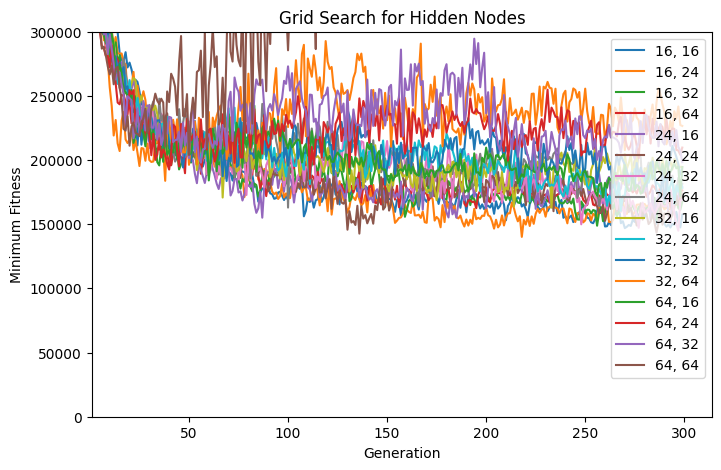

In [ ]:
## Plot grid search
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
for i, result in enumerate(results):
    ax.plot(result['logbook'].select('gen'), result['logbook'].select('min'), label=f'{result["hidden_nodes_1"]}, {result["hidden_nodes_2"]}')
ax.set_xlabel('Generation')
ax.set_ylabel('Minimum Fitness')
ax.set_title('Grid Search for Hidden Nodes')
ax.set_xbound(1)
ax.set_ybound(0, 300000)
ax.legend()
plt.show()


In [ ]:
features = ['PublicHoliday', 'Month', 'Hour', 'Temp', 'Wind speed', 'Visibility', 'HireAvailable', "Dew point"]

myNet = MLP(10, hidden_nodes_1, hidden_nodes_2, 1)
myNet.set_weights_linear(best_ind)

x_values1 = train_data['Temp'].to_list()
y_values1 = train_data['Count'].to_list()

x_values2 = train_data['Temp'].to_list()
y_values2 = [myNet.feed_forward([train_data['PublicHoliday'][i], train_data['Weekend'][i], train_data['Month'][i], train_data['Hour'][i], train_data['Temp'][i], train_data['Wind speed'][i], train_data['Visibility'][i], train_data["HireAvailable"][i], train_data['Dew point'][i], train_data['Year'][i]], train_data['Year'][i]) for i in range(len(train_data))] 

r2_score(y_values1, y_values2)

KeyError: 'PublicHoliday'

In [ ]:
## Grid search for mutation rate

In [ ]:
import pickle
with open('results5.pkl', 'wb') as f:
    pickle.dump(results, f)


    

In [ ]:
results

[{'hidden_nodes_1': 10,
  'hidden_nodes_2': 16,
  'r2': 0.0073096868470814425,
  'logbook': [{'gen': 0,
    'avg': 4705961.527441539,
    'std': 8430433.293366319,
    'min': 397345.12646406115,
    'max': 29561405.773226496},
   {'gen': 1,
    'avg': 7311469.055974523,
    'std': 12147410.809431413,
    'min': 390237.4772445133,
    'max': 43066609.05576356},
   {'gen': 2,
    'avg': 12146063.02205066,
    'std': 10917832.698978519,
    'min': 666299.3145756022,
    'max': 37733820.585349746},
   {'gen': 3,
    'avg': 3273572.9121463993,
    'std': 4976342.0283573,
    'min': 411055.1189000666,
    'max': 16371709.574395113},
   {'gen': 4,
    'avg': 13658724.551079094,
    'std': 26778116.034174465,
    'min': 414412.4319217589,
    'max': 91625321.72934328},
   {'gen': 5,
    'avg': 30220574.86738307,
    'std': 45252983.53286288,
    'min': 402276.77830006264,
    'max': 144419919.82147723},
   {'gen': 6,
    'avg': 27441692.634775568,
    'std': 39917528.74997224,
    'min': 41926

In [ ]:
import json 

with open('results2.txt', 'w') as f:
    f.write(results.__str__())

In [ ]:

best_ind = hof[0]

print(best_ind)
print(toolbox.evaluate(best_ind, myNet, test_data[features].to_numpy(), test_data["Count"].to_numpy()))
myNet.set_weights_linear(best_ind)
inputs = test_data[features].to_numpy()

x_values1 = test_data['Temp'].to_list()
y_values1 = test_data['Count'].to_list()

x_values2 = test_data['Temp'].to_list()
y_values2 = [myNet.feed_forward(i) for i in inputs] 

R2 = r2_score(y_values1, y_values2)
print(R2)
print(y_values2)
plt.scatter(x_values1, y_values1, label='Set 1')
plt.scatter(x_values2, y_values2, label='Set 2')

# Add a legend to explain which line is which
plt.legend()

# Display the plot
plt.show()

NameError: name 'hof' is not defined